In [1]:
!pip install ta optuna --upgrade --no-cache-dir

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 213.3 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1014c4eb22baae006f541c9deaec61789397a1843146ac50395e40851c58ed73
  Stored in directory: /tmp/pip-ephem-wheel-cache-7tzc1vss/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [2]:
import os
import json
from datetime import datetime, timedelta

import yfinance as yf
import pandas as pd
import numpy as np
import ta
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from dateutil.relativedelta import relativedelta

In [3]:
def evaluate_model(model, X_test, y_test, scaler, seq_len, stock_name=""):
    preds = model.predict(X_test, verbose=0)

    # Reconstruct padded arrays for inverse scaling
    pad = np.zeros((preds.shape[0], len(FEATURES)))
    pad[:, FEATURES.index('close')] = preds[:, 0]
    pred_prices = scaler.inverse_transform(pad)[:, FEATURES.index('close')]

    pad_y = np.zeros((y_test.shape[0], len(FEATURES)))
    pad_y[:, FEATURES.index('close')] = y_test
    actual_prices = scaler.inverse_transform(pad_y)[:, FEATURES.index('close')]

    # metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, pred_prices))
    mae = mean_absolute_error(actual_prices, pred_prices)
    r2 = r2_score(actual_prices, pred_prices)

    print(f"\n📊 Evaluation for {stock_name if stock_name else 'Model'}:")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)

    return {
        "stock": stock_name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "y_true": actual_prices,
        "y_pred": pred_prices
    }

def plot_actual_vs_predicted(y_true, y_pred, stock_name="", years=10, step=30):
    # Generate dates automatically
    today = datetime.today()
    start_date = today - relativedelta(days=len(y_true))  # enough days for the sequence
    dates = pd.date_range(start=start_date, end=today, periods=len(y_true))

    df = pd.DataFrame({"Date": dates, "Actual": y_true, "Predicted": y_pred})

    # Filter last N years
    cutoff = today - relativedelta(years=years)
    df = df[df["Date"] >= cutoff]

    plt.figure(figsize=(14, 7))

    # Plot smooth lines
    plt.plot(df["Date"], df["Actual"], label="Actual", color="blue", alpha=0.7)
    plt.plot(df["Date"], df["Predicted"], label="Predicted", color="orange", alpha=0.7)

    # Add staggered markers
    plt.scatter(df["Date"][::step], df["Actual"][::step], color="blue", marker="o", s=40, alpha=0.6)
    plt.scatter(df["Date"][::step], df["Predicted"][::step], color="orange", marker="x", s=40, alpha=0.8)

    plt.title(f"Actual vs Predicted - {stock_name} (Last {years} Years)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [4]:
stock_list = ['RELIANCE.NS','HDFCBANK.NS','BHARTIARTL.NS','TCS.NS','ICICIBANK.NS','SBIN.NS','INFY.NS','HINDUNILVR.NS','BAJFINANCE.NS','ITC.NS']
START_DATE = '2005-01-01'
END_DATE = '2025-08-22'

MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)
BASE_MODEL_PATH = os.path.join(MODELS_DIR, "base_model.h5")
SCALER_PATH = os.path.join(MODELS_DIR, "scaler.pkl")
PARAMS_PATH = os.path.join(MODELS_DIR, "params.json")
MASTER_CSV = "master_data.csv"

FEATURES = ['open', 'high', 'low', 'close', 'volume', 'momentum', 'volatility',
            'roc', 'williams_r', 'SMA_20', 'EMA_20', 'MACD', 'RSI',
            'BB_high', 'BB_low', 'STOCH', 'ATR']

DEFAULT_PARAMS = {'units': 128, 'dropout': 0.2, 'lr': 1e-3, 'batch_size': 32, 'seq_len': 60}

In [5]:
def _normalize_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0].lower() for c in df.columns]
    else:
        df.columns = [c.lower() for c in df.columns]
    return df

def compute_technical_indicators(df):

    df = df.copy()
    df['SMA_20'] = ta.trend.sma_indicator(df['close'], window=20)
    df['EMA_20'] = ta.trend.ema_indicator(df['close'], window=20)
    df['MACD'] = ta.trend.macd_diff(df['close'])
    df['RSI'] = ta.momentum.rsi(df['close'], window=14)
    df['BB_high'] = ta.volatility.bollinger_hband(df['close'], window=20)
    df['BB_low'] = ta.volatility.bollinger_lband(df['close'], window=20)
    df['STOCH'] = ta.momentum.stoch(df['high'], df['low'], df['close'], window=14)
    df['ATR'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
    df['momentum'] = df['close'] - df['close'].shift(1)
    df['volatility'] = df['close'].rolling(10).std()
    df['roc'] = ta.momentum.roc(df['close'], window=5)
    df['williams_r'] = ta.momentum.williams_r(df['high'], df['low'], df['close'], lbp=14)
    return df


def get_stock_data(symbol, start=START_DATE, end=END_DATE):
    df = yf.download(symbol, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data for {symbol} between {start} and {end}")
    df = df.reset_index()
    df = _normalize_columns(df)
    df = compute_technical_indicators(df)
    df['symbol'] = symbol

    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    return df.dropna().reset_index(drop=True)

In [6]:
def build_master_dataset(symbols=stock_list, start=START_DATE, end=END_DATE, save=True):
    dfs = []
    for s in symbols:
        print(f"Downloading {s} ...")
        dfs.append(get_stock_data(s, start=start, end=end))
    master = pd.concat(dfs, ignore_index=True)
    if save:
        master.to_csv(MASTER_CSV, index=False)
        print(f"Saved master CSV -> {MASTER_CSV}, rows={len(master)}")
    return master

def load_master():
    if not os.path.exists(MASTER_CSV):
        return None
    m = pd.read_csv(MASTER_CSV)
    if 'date' in m.columns:
        m['date'] = pd.to_datetime(m['date'])
    return m

In [7]:
def fit_and_save_scaler(master_df):
    scaler = MinMaxScaler()
    master_df = master_df.copy()
    master_df[FEATURES] = scaler.fit_transform(master_df[FEATURES])
    joblib.dump(scaler, SCALER_PATH)
    print("Saved scaler to", SCALER_PATH)
    return scaler, master_df

def load_scaler():
    if not os.path.exists(SCALER_PATH):
        raise FileNotFoundError("Scaler not found - run the base training first")
    return joblib.load(SCALER_PATH)

def create_sequences_from_values(values, seq_len):
    X, y = [], []
    for i in range(seq_len, len(values)):
        X.append(values[i-seq_len:i])
        y.append(values[i, FEATURES.index('close')])
    return np.array(X), np.array(y)

def create_sequences_multi(df, seq_len):
    X, y = [], []
    for symbol in df['symbol'].unique():
        stock_df = df[df['symbol'] == symbol].sort_values(by='date').reset_index(drop=True)
        vals = stock_df[FEATURES].values
        x_sym, y_sym = create_sequences_from_values(vals, seq_len)
        if len(x_sym):
            X.append(x_sym)
            y.append(y_sym)
    if len(X) == 0:
        return np.empty((0, seq_len, len(FEATURES))), np.empty((0,))
    X = np.vstack(X)
    y = np.hstack(y)
    return X, y

In [8]:
def build_model(units, dropout, lr, seq_len):
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=True, input_shape=(seq_len, len(FEATURES)))),
        Dropout(dropout),
        GRU(max(1, units // 2), return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [9]:
def tune_and_train_base(master_df, n_trials=10, optuna_tune=True, seed=42):

    scaler, master_scaled = fit_and_save_scaler(master_df)
    if optuna_tune:
        def objective(trial):
            units = trial.suggest_int('units', 32, 256)
            dropout = trial.suggest_float('dropout', 0.1, 0.5)
            lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
            batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
            seq_len = trial.suggest_int('seq_len', 30, 90)

            X, y = create_sequences_multi(master_scaled, seq_len)
            if len(X) == 0:
                return np.inf
            split = int(0.8 * len(X))
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            model = build_model(units, dropout, lr, seq_len)
            es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=batch_size, callbacks=[es], verbose=0)

            preds = model.predict(X_test, verbose=0)
            pad = np.zeros((preds.shape[0], len(FEATURES)))
            pad[:, FEATURES.index('close')] = preds[:, 0]
            pred_prices = scaler.inverse_transform(pad)[:, FEATURES.index('close')]

            pad_y = np.zeros((y_test.shape[0], len(FEATURES)))
            pad_y[:, FEATURES.index('close')] = y_test
            actual_prices = scaler.inverse_transform(pad_y)[:, FEATURES.index('close')]

            return np.sqrt(mean_squared_error(actual_prices, pred_prices))

      #  study = optuna.create_study(direction='minimize')
        sampler = optuna.samplers.TPESampler(seed=seed)
        study = optuna.create_study(direction='minimize', sampler=sampler)
        study.optimize(objective, n_trials=n_trials)
        best = study.best_trial.params
        params = {
            'units': best['units'],
            'dropout': best['dropout'],
            'lr': best['lr'],
            'batch_size': best['batch_size'],
            'seq_len': best['seq_len']
        }
        print("Optuna best params:", params)
    else:
        params = DEFAULT_PARAMS.copy()
        print("Using default params:", params)


    with open(PARAMS_PATH, 'w') as f:
        json.dump(params, f)


    seq_len = params['seq_len']
    X, y = create_sequences_multi(master_scaled, seq_len)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    base_model = build_model(params['units'], params['dropout'], params['lr'], seq_len)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    base_model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=params['batch_size'], callbacks=[es])

    base_model.save(BASE_MODEL_PATH)
    print("Saved base model ->", BASE_MODEL_PATH)

    base_eval = evaluate_model(base_model, X_test, y_test, scaler, seq_len, stock_name="BASE_MODEL")
    plot_actual_vs_predicted(base_eval["y_true"], base_eval["y_pred"], "BASE_MODEL")

    master_df.to_csv(MASTER_CSV, index=False)
    print("Saved master csv.")

    return base_model, params

In [10]:
def fine_tune_stock(symbol, epochs=5, lr_override=None, seq_len_override=None, save=True):

    if not os.path.exists(BASE_MODEL_PATH):
        raise FileNotFoundError("Base model not found. Train base model first.")
    if not os.path.exists(SCALER_PATH):
        raise FileNotFoundError("Scaler not found. Fit scaler first.")

    params = json.load(open(PARAMS_PATH)) if os.path.exists(PARAMS_PATH) else DEFAULT_PARAMS
    seq_len = seq_len_override or params['seq_len']


    base_model = load_model(BASE_MODEL_PATH, compile=False)


    use_lr = (lr_override if lr_override is not None else max(1e-5, params['lr'] / 5))
    base_model.compile(optimizer=Adam(learning_rate=use_lr), loss=MeanSquaredError())


    master = load_master()
    if master is None or symbol not in master['symbol'].unique():

        stock_df = get_stock_data(symbol)
    else:
        stock_df = master[master['symbol'] == symbol].sort_values(by='date').reset_index(drop=True)

    scaler = load_scaler()
    stock_df_scaled = stock_df.copy()
    stock_df_scaled[FEATURES] = scaler.transform(stock_df_scaled[FEATURES])

    X_stock, y_stock = create_sequences_from_values(stock_df_scaled[FEATURES].values, seq_len)
    if len(X_stock) == 0:
        print(f"Not enough data to fine-tune for {symbol}")
        return None


    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    base_model.fit(X_stock, y_stock, epochs=epochs, batch_size=max(1, len(X_stock)//10), callbacks=[es], verbose=1, validation_split=0.1)


    stock_model_path = os.path.join(MODELS_DIR, f"{symbol.replace('.','_')}_ft.h5")

    stock_eval = evaluate_model(base_model, X_stock, y_stock, scaler, seq_len, stock_name=symbol)
    plot_actual_vs_predicted(stock_eval["y_true"], stock_eval["y_pred"], symbol)

    if save:
        base_model.save(stock_model_path)
        print(f"Saved fine-tuned model for {symbol} -> {stock_model_path}")
    return base_model

In [11]:
def forecast_next_days(symbol, N=5, use_finetuned=True):

    master = load_master()
    if master is None:
        raise FileNotFoundError("Master CSV not found. Train base model first.")


    stock_model_path = os.path.join(MODELS_DIR, f"{symbol.replace('.','_')}_ft.h5")
    if use_finetuned and os.path.exists(stock_model_path):
        model = load_model(stock_model_path)
        print(f"Using fine-tuned model for {symbol}")
    else:
        model = load_model(BASE_MODEL_PATH)
        print(f"Using base model for {symbol}")

    params = json.load(open(PARAMS_PATH)) if os.path.exists(PARAMS_PATH) else DEFAULT_PARAMS
    seq_len = params['seq_len']


    stock_df = master[master['symbol'] == symbol].sort_values(by='date').reset_index(drop=True)
    if stock_df.empty:
        raise ValueError(f"No data for {symbol} in master dataset")

    scaler = load_scaler()
    stock_scaled = stock_df.copy()
    stock_scaled[FEATURES] = scaler.transform(stock_scaled[FEATURES])
    last_sequence = stock_scaled[FEATURES].values[-seq_len:]
    forecast = []
    current_input = last_sequence.copy()

    for _ in range(N):
        inp = current_input.reshape(1, seq_len, len(FEATURES))
        pred_scaled = model.predict(inp, verbose=0)[0, 0]
        pred_full = np.zeros((len(FEATURES),))
        pred_full[FEATURES.index('close')] = pred_scaled
        unscaled_pred = scaler.inverse_transform([pred_full])[0][FEATURES.index('close')]
        forecast.append(unscaled_pred)


        new_row = current_input[-1].copy()
        new_row[FEATURES.index('close')] = pred_scaled
        current_input = np.vstack((current_input[1:], new_row))

    last_date = stock_df['date'].iloc[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=N, freq='B')


    plt.figure(figsize=(8, 4))
    plt.plot(forecast_dates, forecast, marker='o', linestyle='--')
    plt.title(f"{N}-day Forecast for {symbol} (use_finetuned={use_finetuned})")
    plt.xlabel("Date")
    plt.ylabel("Forecasted Close")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return list(zip(forecast_dates, forecast))

/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1135910803.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


[*********************100%***********************]  1 of 1 completed


Saved master CSV -> master_data.csv, rows=50610
Saved scaler to models/scaler.pkl
Saved scaler to models/scaler.pkl
Using default params: {'units': 128, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32, 'seq_len': 60}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0028 - val_loss: 1.1256e-04
Epoch 2/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 3.2925e-04 - val_loss: 2.1221e-04
Epoch 3/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 2.6002e-04 - val_loss: 4.4907e-04
Epoch 4/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 2.2800e-04 - val_loss: 1.3710e-04
Epoch 5/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 2.0222e-04 - val_loss: 6.1709e-05
Epoch 6/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.7687e-04 - val_loss: 4.4613e-05
Epoch 7/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.9177e-04 - val_loss: 5.7646e-05
Epoch 8/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.8003e-04 - val_loss: 4.7948e-05
Epoch 9/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.8919e-04 - val_loss: 1.9272e-04
Epoch 10/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.6962e-04 - val_loss: 6.3061e-05
Epoch 11/50
1126/1126 ━

Saved base model -> models/base_model.h5

📊 Evaluation for BASE_MODEL:
RMSE: 8.365144276737903
MAE: 5.412973209169493
R²: 0.9985270556523667


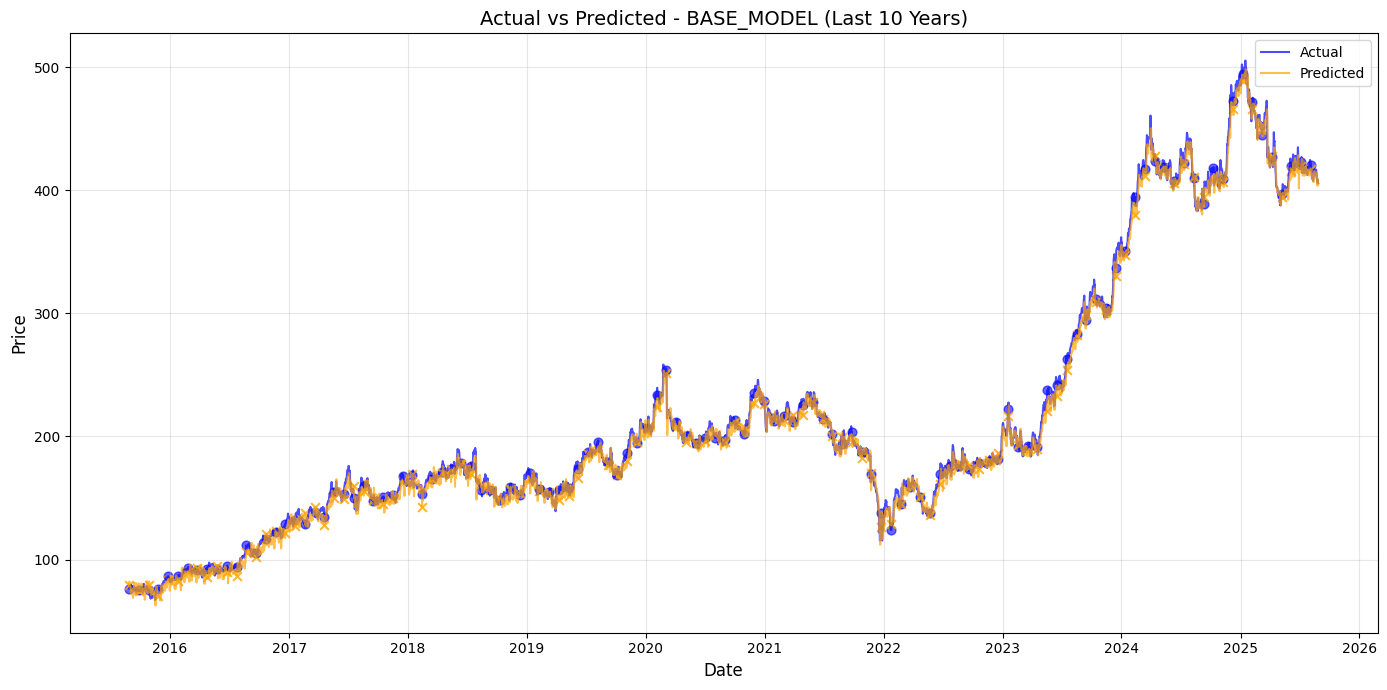

Saved master csv.
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 4.1775e-05 - val_loss: 1.8950e-05
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.0920e-05 - val_loss: 1.9741e-05
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.0884e-05 - val_loss: 1.8137e-05
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 4.0679e-05 - val_loss: 2.2599e-05
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.8148e-05 - val_loss: 1.8094e-05

📊 Evaluation for RELIANCE.NS:
RMSE: 11.366018613233944
MAE: 6.829390314395203
R²: 0.9993138615097422


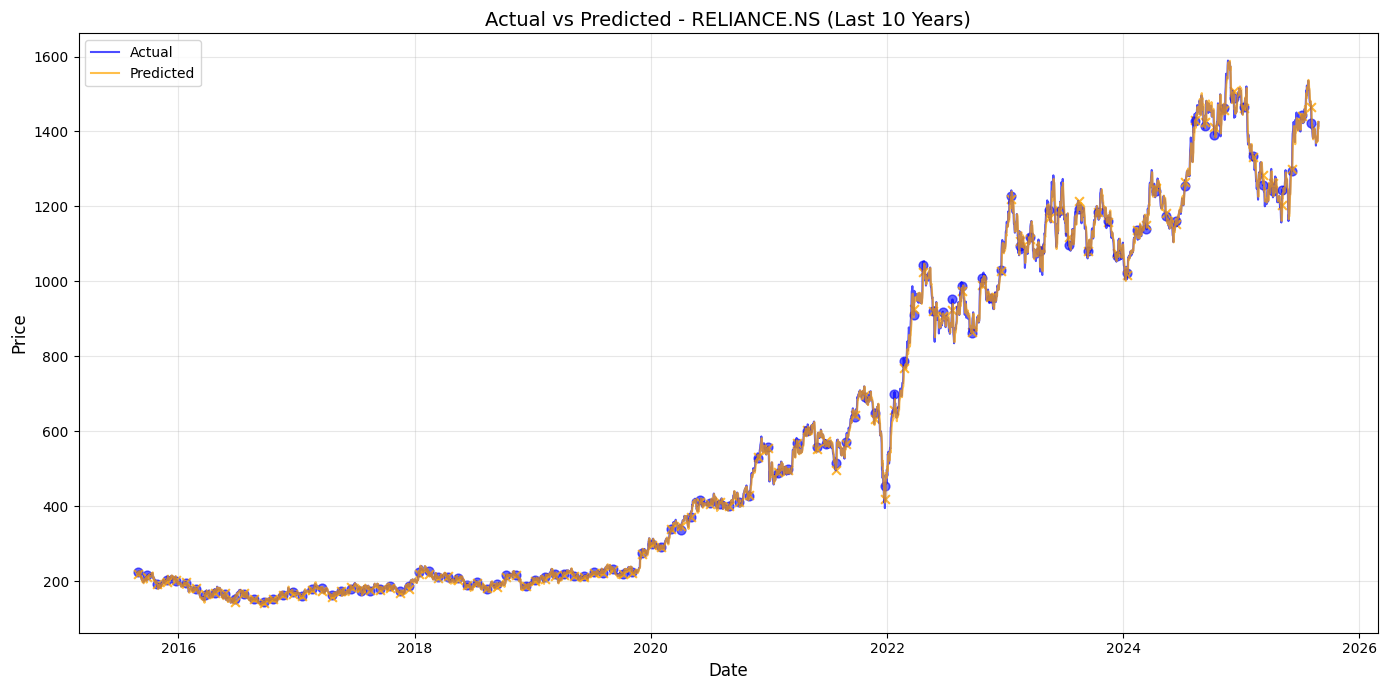

Saved fine-tuned model for RELIANCE.NS -> models/RELIANCE_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 3.7768e-05 - val_loss: 6.4600e-06
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.2449e-05 - val_loss: 6.4768e-06
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.4137e-05 - val_loss: 6.0195e-06
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.2480e-05 - val_loss: 6.1371e-06
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.3069e-05 - val_loss: 5.6598e-06

📊 Evaluation for HDFCBANK.NS:
RMSE: 7.913252766197527
MAE: 6.159854503885693
R²: 0.9992168973171126


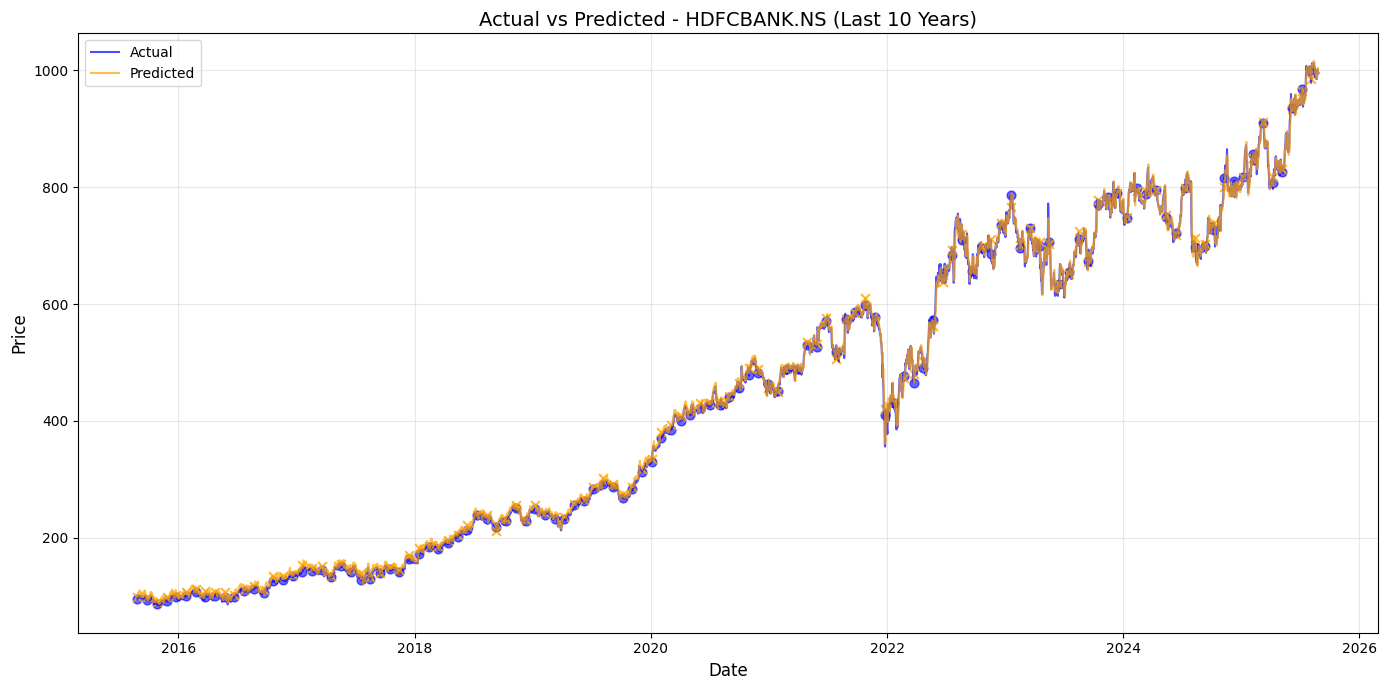

Saved fine-tuned model for HDFCBANK.NS -> models/HDFCBANK_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 2.0572e-05 - val_loss: 2.6468e-05
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0211e-05 - val_loss: 2.4772e-05
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9339e-05 - val_loss: 2.9530e-05
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.9119e-05 - val_loss: 2.9500e-05
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7997e-05 - val_loss: 2.5943e-05

📊 Evaluation for BHARTIARTL.NS:
RMSE: 10.519327500366044
MAE: 6.840263389364832
R²: 0.9991933658314774


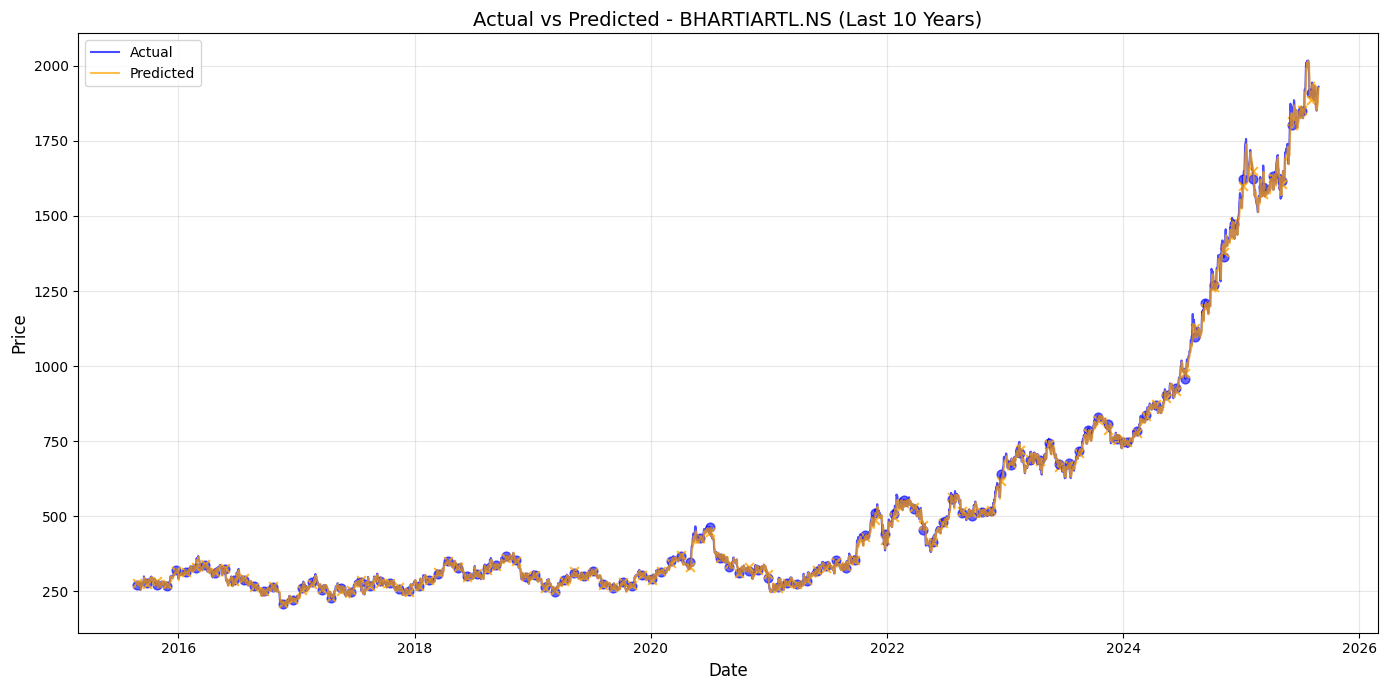

Saved fine-tuned model for BHARTIARTL.NS -> models/BHARTIARTL_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 3.1100e-04 - val_loss: 1.7898e-04
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.6057e-04 - val_loss: 1.7739e-04
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.0087e-04 - val_loss: 1.7675e-04
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.2158e-04 - val_loss: 1.6691e-04
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.4757e-04 - val_loss: 1.6086e-04

📊 Evaluation for TCS.NS:
RMSE: 29.17490142381744
MAE: 17.146503151778475
R²: 0.9994551410236422


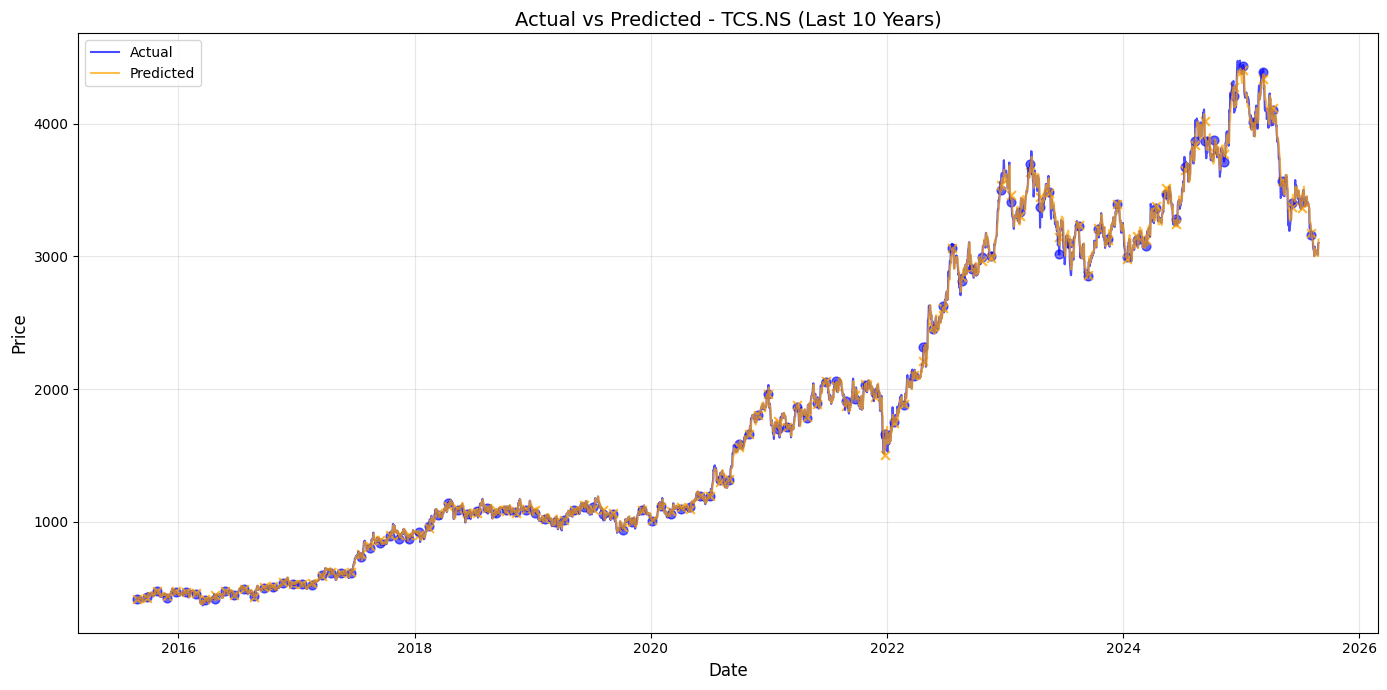

Saved fine-tuned model for TCS.NS -> models/TCS_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 3.4244e-05 - val_loss: 1.2302e-05
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.0894e-05 - val_loss: 1.0734e-05
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8868e-05 - val_loss: 1.0930e-05
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.9184e-05 - val_loss: 1.2099e-05
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.0663e-05 - val_loss: 1.1916e-05

📊 Evaluation for ICICIBANK.NS:
RMSE: 8.098647589315478
MAE: 5.462197322950583
R²: 0.9994478838598359


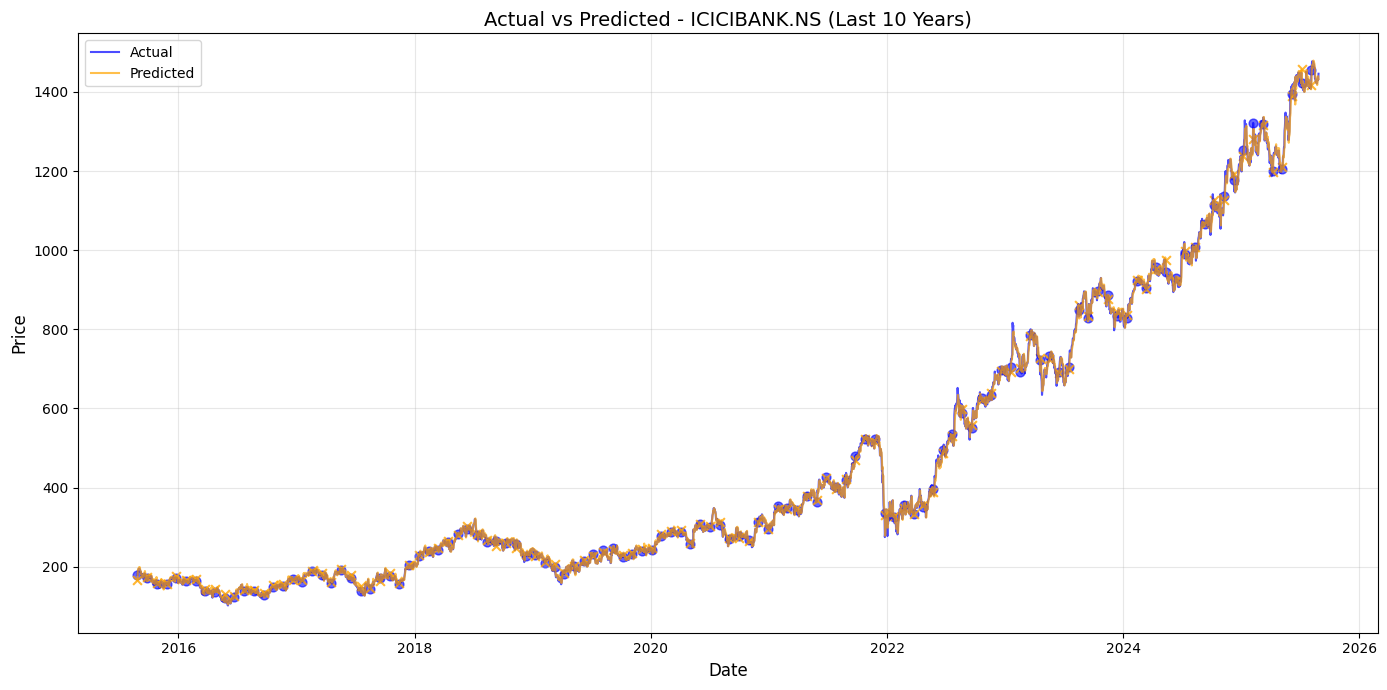

Saved fine-tuned model for ICICIBANK.NS -> models/ICICIBANK_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 3.1865e-05 - val_loss: 7.8812e-06
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.1021e-05 - val_loss: 7.7648e-06
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8492e-05 - val_loss: 7.8501e-06
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8906e-05 - val_loss: 7.8828e-06
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.7564e-05 - val_loss: 7.7510e-06

📊 Evaluation for SBIN.NS:
RMSE: 6.479026355436965
MAE: 4.405293868626704
R²: 0.998865868259483


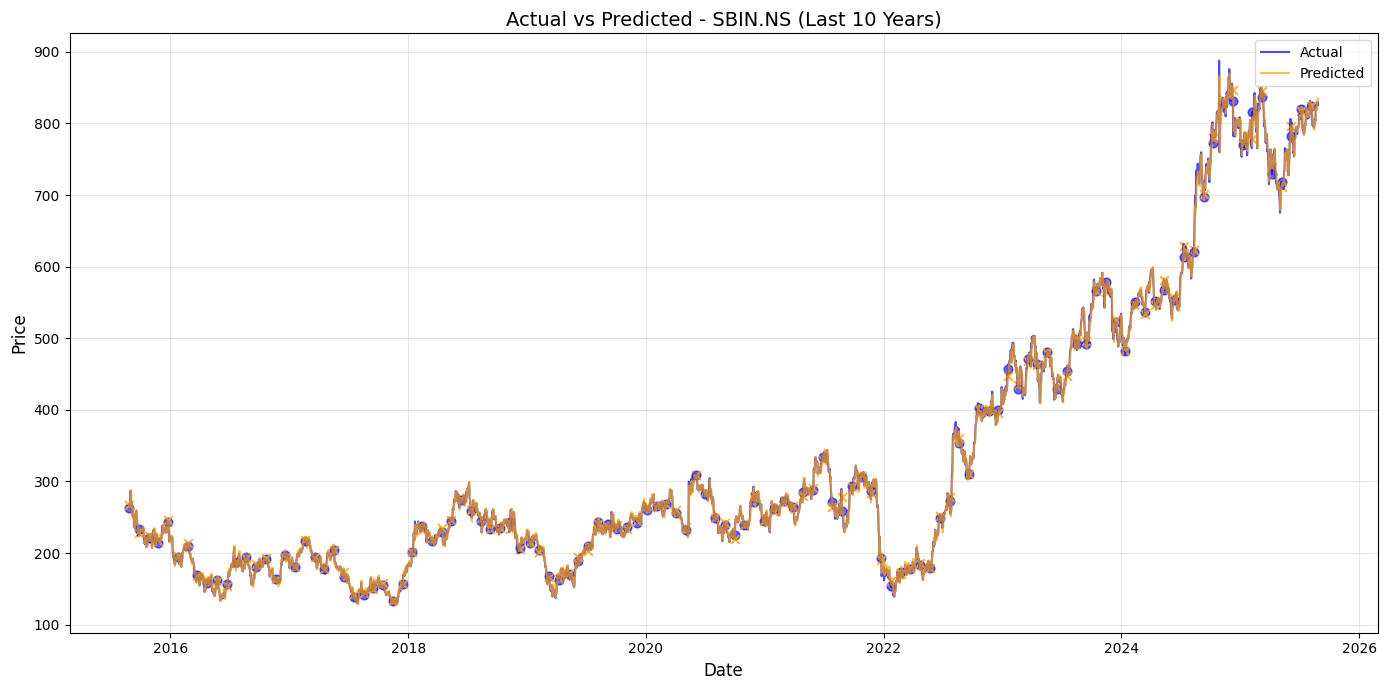

Saved fine-tuned model for SBIN.NS -> models/SBIN_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 5.2813e-05 - val_loss: 3.4853e-05
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.4087e-05 - val_loss: 3.5241e-05
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.2379e-05 - val_loss: 3.1614e-05
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.8578e-05 - val_loss: 3.3325e-05
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.0758e-05 - val_loss: 3.2657e-05

📊 Evaluation for INFY.NS:
RMSE: 13.500979663485214
MAE: 8.284646533580279
R²: 0.9993324844237687


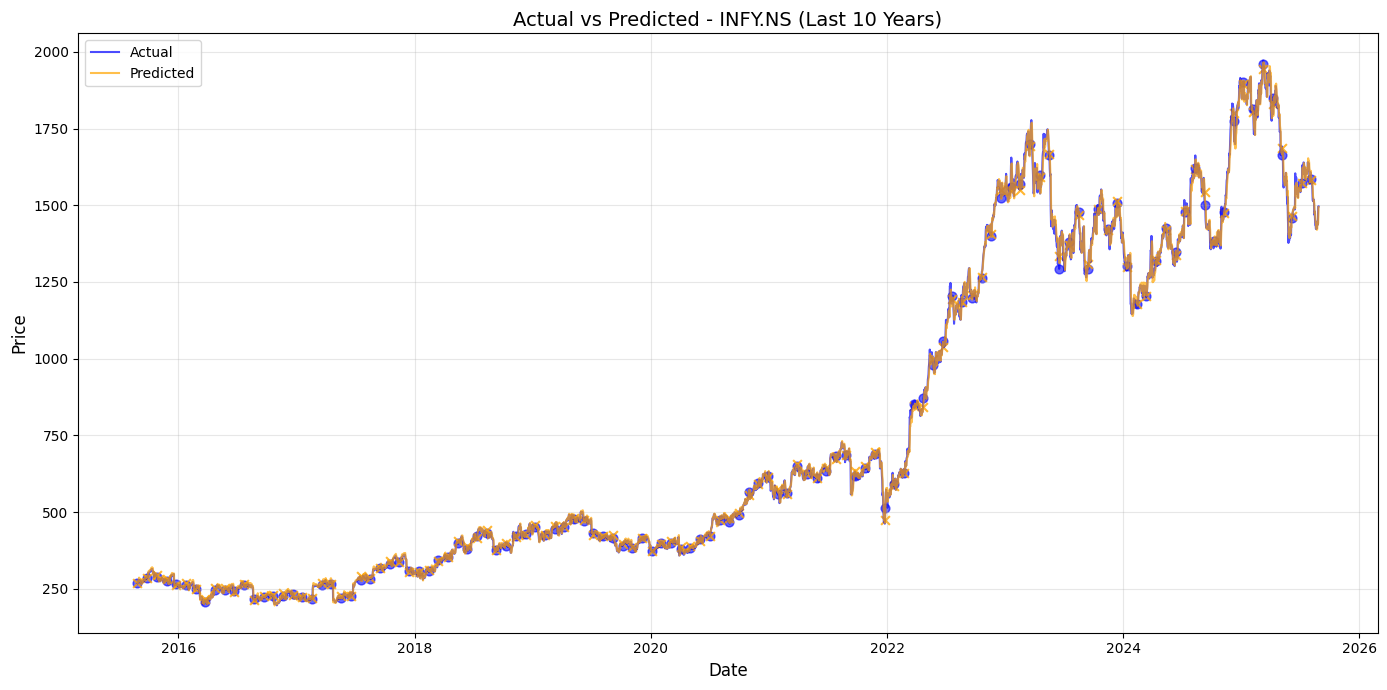

Saved fine-tuned model for INFY.NS -> models/INFY_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 1.9844e-04 - val_loss: 5.4710e-05
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.9390e-04 - val_loss: 4.9674e-05
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.9354e-04 - val_loss: 4.9651e-05
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.8551e-04 - val_loss: 5.3452e-05
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7303e-04 - val_loss: 5.0406e-05

📊 Evaluation for HINDUNILVR.NS:
RMSE: 20.418394057202782
MAE: 11.873677712020303
R²: 0.9994701091975188


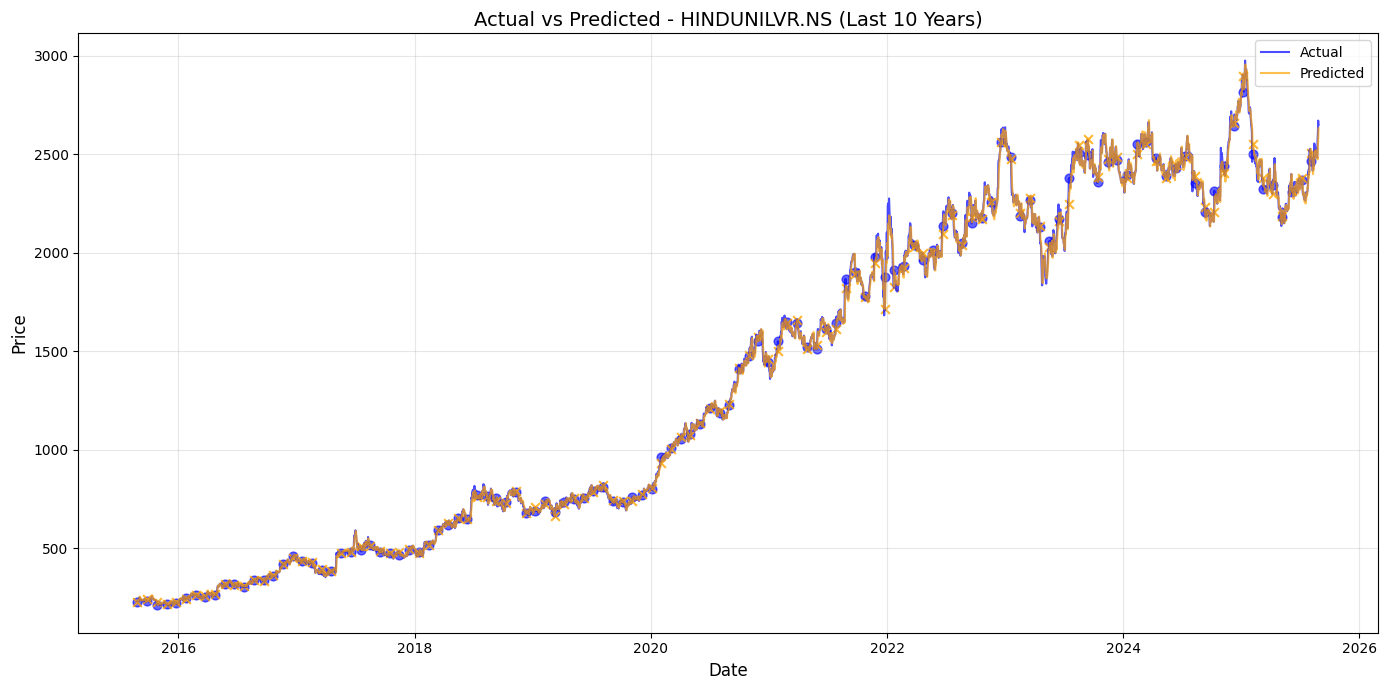

Saved fine-tuned model for HINDUNILVR.NS -> models/HINDUNILVR_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 5.4961e-05 - val_loss: 8.8355e-06
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.5893e-05 - val_loss: 8.3139e-06
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.0597e-05 - val_loss: 8.4166e-06
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.3280e-05 - val_loss: 8.6446e-06
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.7804e-05 - val_loss: 8.5613e-06

📊 Evaluation for BAJFINANCE.NS:
RMSE: 9.15946119909216
MAE: 5.209121632380341
R²: 0.9989474650097031


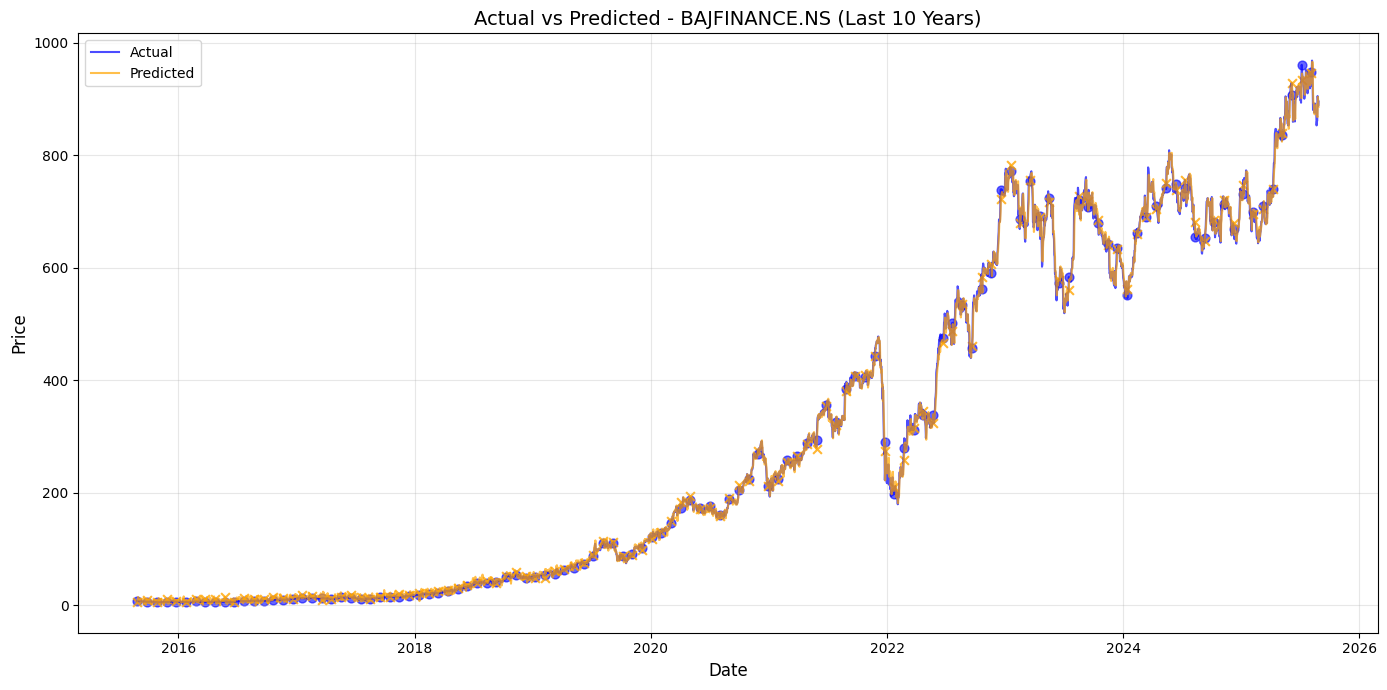

Saved fine-tuned model for BAJFINANCE.NS -> models/BAJFINANCE_NS_ft.h5
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 4.2769e-05 - val_loss: 1.4297e-06
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.2748e-05 - val_loss: 1.6377e-06
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.0770e-05 - val_loss: 1.4021e-06
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.9217e-05 - val_loss: 1.3962e-06
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.7725e-05 - val_loss: 1.6960e-06

📊 Evaluation for ITC.NS:
RMSE: 3.882728265978583
MAE: 2.9656272769598693
R²: 0.9989256603255873


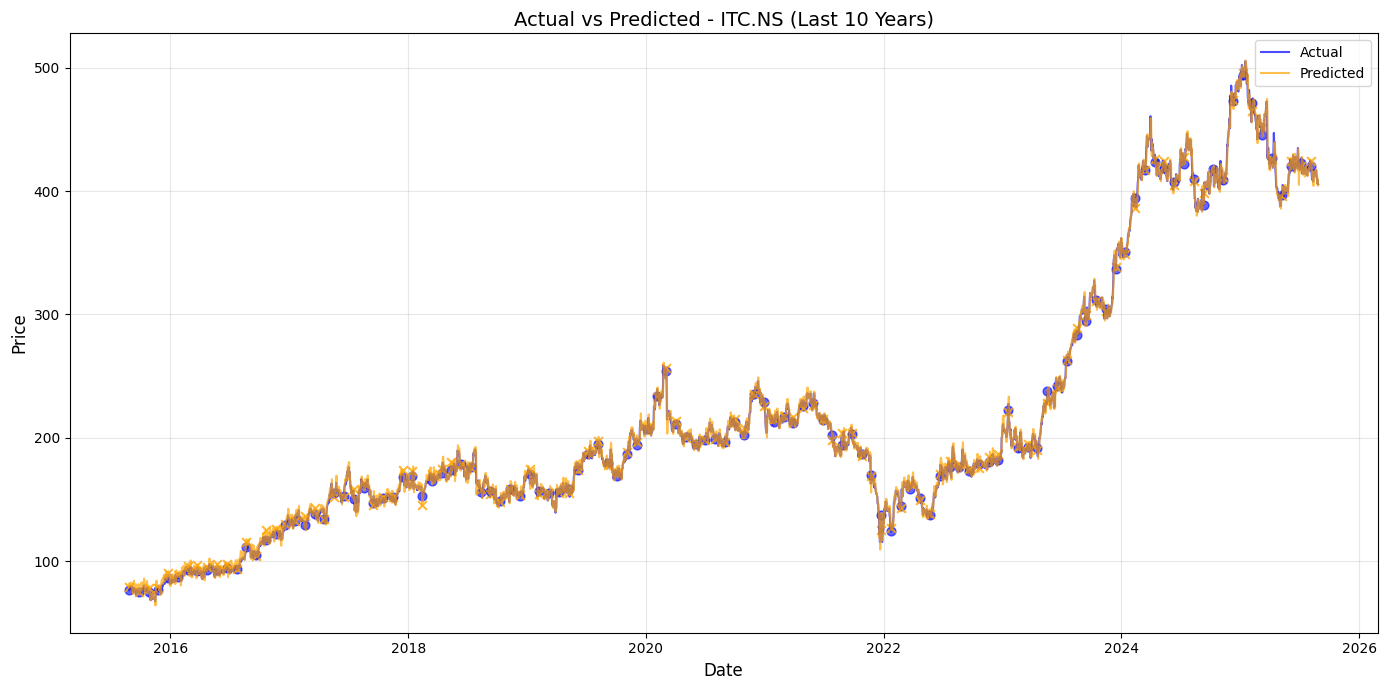

Saved fine-tuned model for ITC.NS -> models/ITC_NS_ft.h5
Forecast for SBIN.NS (using fine-tuned):


Using fine-tuned model for SBIN.NS


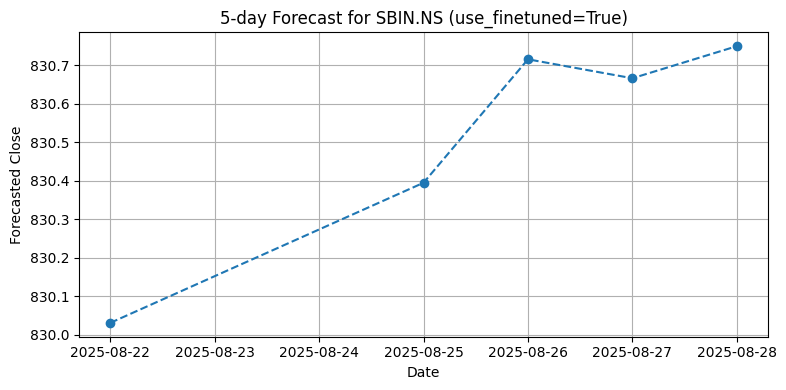

2025-08-22 830.03
2025-08-25 830.39
2025-08-26 830.72
2025-08-27 830.67
2025-08-28 830.75


In [12]:
def add_new_stock_and_retrain_base(symbol, retrain_base=False, optuna_tune=False):
    """
    Add new stock to master; if retrain_base=True then:
      - append stock history to master
      - refit scaler on full master (required when adding very different stocks)
      - retrain base model (heavy)
    """
    master = load_master()
    if master is None or master.empty:
      master = pd.DataFrame()

    new_stock = get_stock_data(symbol)

    master = pd.concat([master, new_stock], ignore_index=True).drop_duplicates(subset=['date','symbol']).reset_index(drop=True)
    master.to_csv(MASTER_CSV, index=False)
    print(f"Added {symbol} to master ({len(new_stock)} rows).")

    if retrain_base:
        print("Refitting scaler and retraining base model (this may take time)...")
        tune_and_train_base(master_df=master, n_trials=10 if optuna_tune else 0, optuna_tune=optuna_tune)
    else:
        # Only attempt to fine-tune if there's enough data in the master for this stock
        if len(master[master['symbol'] == symbol]) >= DEFAULT_PARAMS['seq_len'] + 14: # seq_len for sequences, 14 for ATR
             fine_tune_stock(symbol, epochs=5)
        else:
             print(f"Not enough data in master for {symbol} to fine-tune.")


    return True


if __name__ == "__main__":

    if not os.path.exists(MASTER_CSV):
        master = build_master_dataset(stock_list)
    else:
        master = load_master()

    if not os.path.exists(SCALER_PATH):
        scaler, master_scaled = fit_and_save_scaler(master)
    else:
        scaler = load_scaler()

    if not os.path.exists(BASE_MODEL_PATH):
        base_model, params = tune_and_train_base(master, n_trials=10, optuna_tune=False)
    else:
        print("Base model found, skipping full training.")


    for s in stock_list:
        fine_tune_stock(s, epochs=5)


    print("Forecast for SBIN.NS (using fine-tuned):")
    fc = forecast_next_days('SBIN.NS', N=5, use_finetuned=True)
    for d, p in fc:
      print(d.date(), round(p, 2))

In [13]:
add_new_stock_and_retrain_base('ASIANPAINT.NS')

In [15]:
#Download all files
!zip -r models.zip models/
from google.colab import files
#files.download("models.zip")

updating: models/ (stored 0%)
updating: models/TCS_NS_ft.h5 (deflated 7%)
updating: models/base_model.h5 (deflated 7%)
updating: models/INFY_NS_ft.h5 (deflated 7%)
updating: models/scaler.pkl (deflated 29%)
updating: models/BAJFINANCE_NS_ft.h5 (deflated 7%)
updating: models/SBIN_NS_ft.h5 (deflated 7%)
updating: models/HINDUNILVR_NS_ft.h5 (deflated 7%)
updating: models/ICICIBANK_NS_ft.h5 (deflated 7%)
updating: models/BHARTIARTL_NS_ft.h5 (deflated 7%)
updating: models/RELIANCE_NS_ft.h5 (deflated 7%)
updating: models/HDFCBANK_NS_ft.h5 (deflated 7%)
updating: models/params.json (deflated 13%)
updating: models/ITC_NS_ft.h5 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>